In [1]:
# %reset -f

import datetime
import gurobipy as gp
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import pickle
import requests
import re
import scipy as sci
import sympy as sym
import warnings

from bs4 import BeautifulSoup
from gurobipy import GRB
from matplotlib.ticker import MultipleLocator
from numpy import sqrt, exp, log, sin, cos, pi
from numba import jit

# 全局绘图样式设置

# 整体风格
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# 字体
plt.rcParams['font.family'] = 'Times New Roman + Microsoft YaHei'
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# 取消右侧和上方的刻度线
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# 网格设置
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.unicode_minus'] = False
# 主副刻度线
plt.rcParams['axes.linewidth'] = 1.3  # 主刻度线的粗细

plt.rcParams['xtick.major.width'] = 1.3  # x:主刻度:宽度
plt.rcParams['xtick.major.size'] = 5.3     # x:主刻度:长度
plt.rcParams['xtick.minor.width'] = 1.3  # x:副刻度:宽度
plt.rcParams['xtick.minor.size'] = 3     # x:副刻度:长度

plt.rcParams['ytick.major.width'] = 1.3  # y:主刻度:宽度
plt.rcParams['ytick.major.size'] = 5.3     # y:主刻度:长度
plt.rcParams['ytick.minor.width'] = 1.3  # y:副刻度:宽度
plt.rcParams['ytick.minor.size'] = 3     # y:副刻度:长度
# 设置使用latex
plt.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')

# %matplotlib inline
# matplotlib.use('TkAgg')



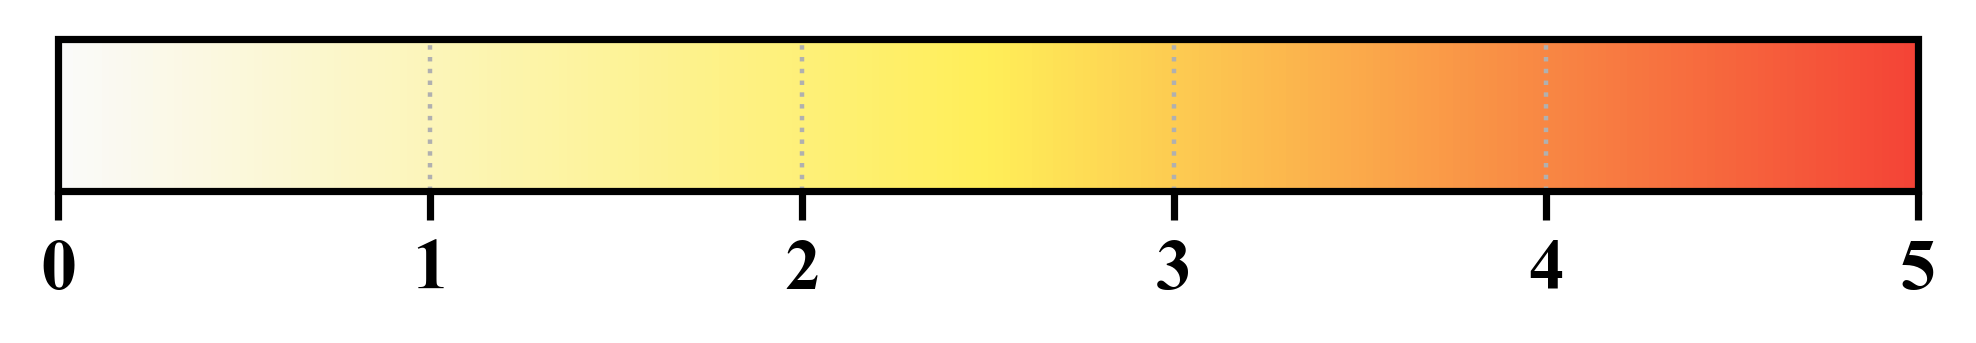
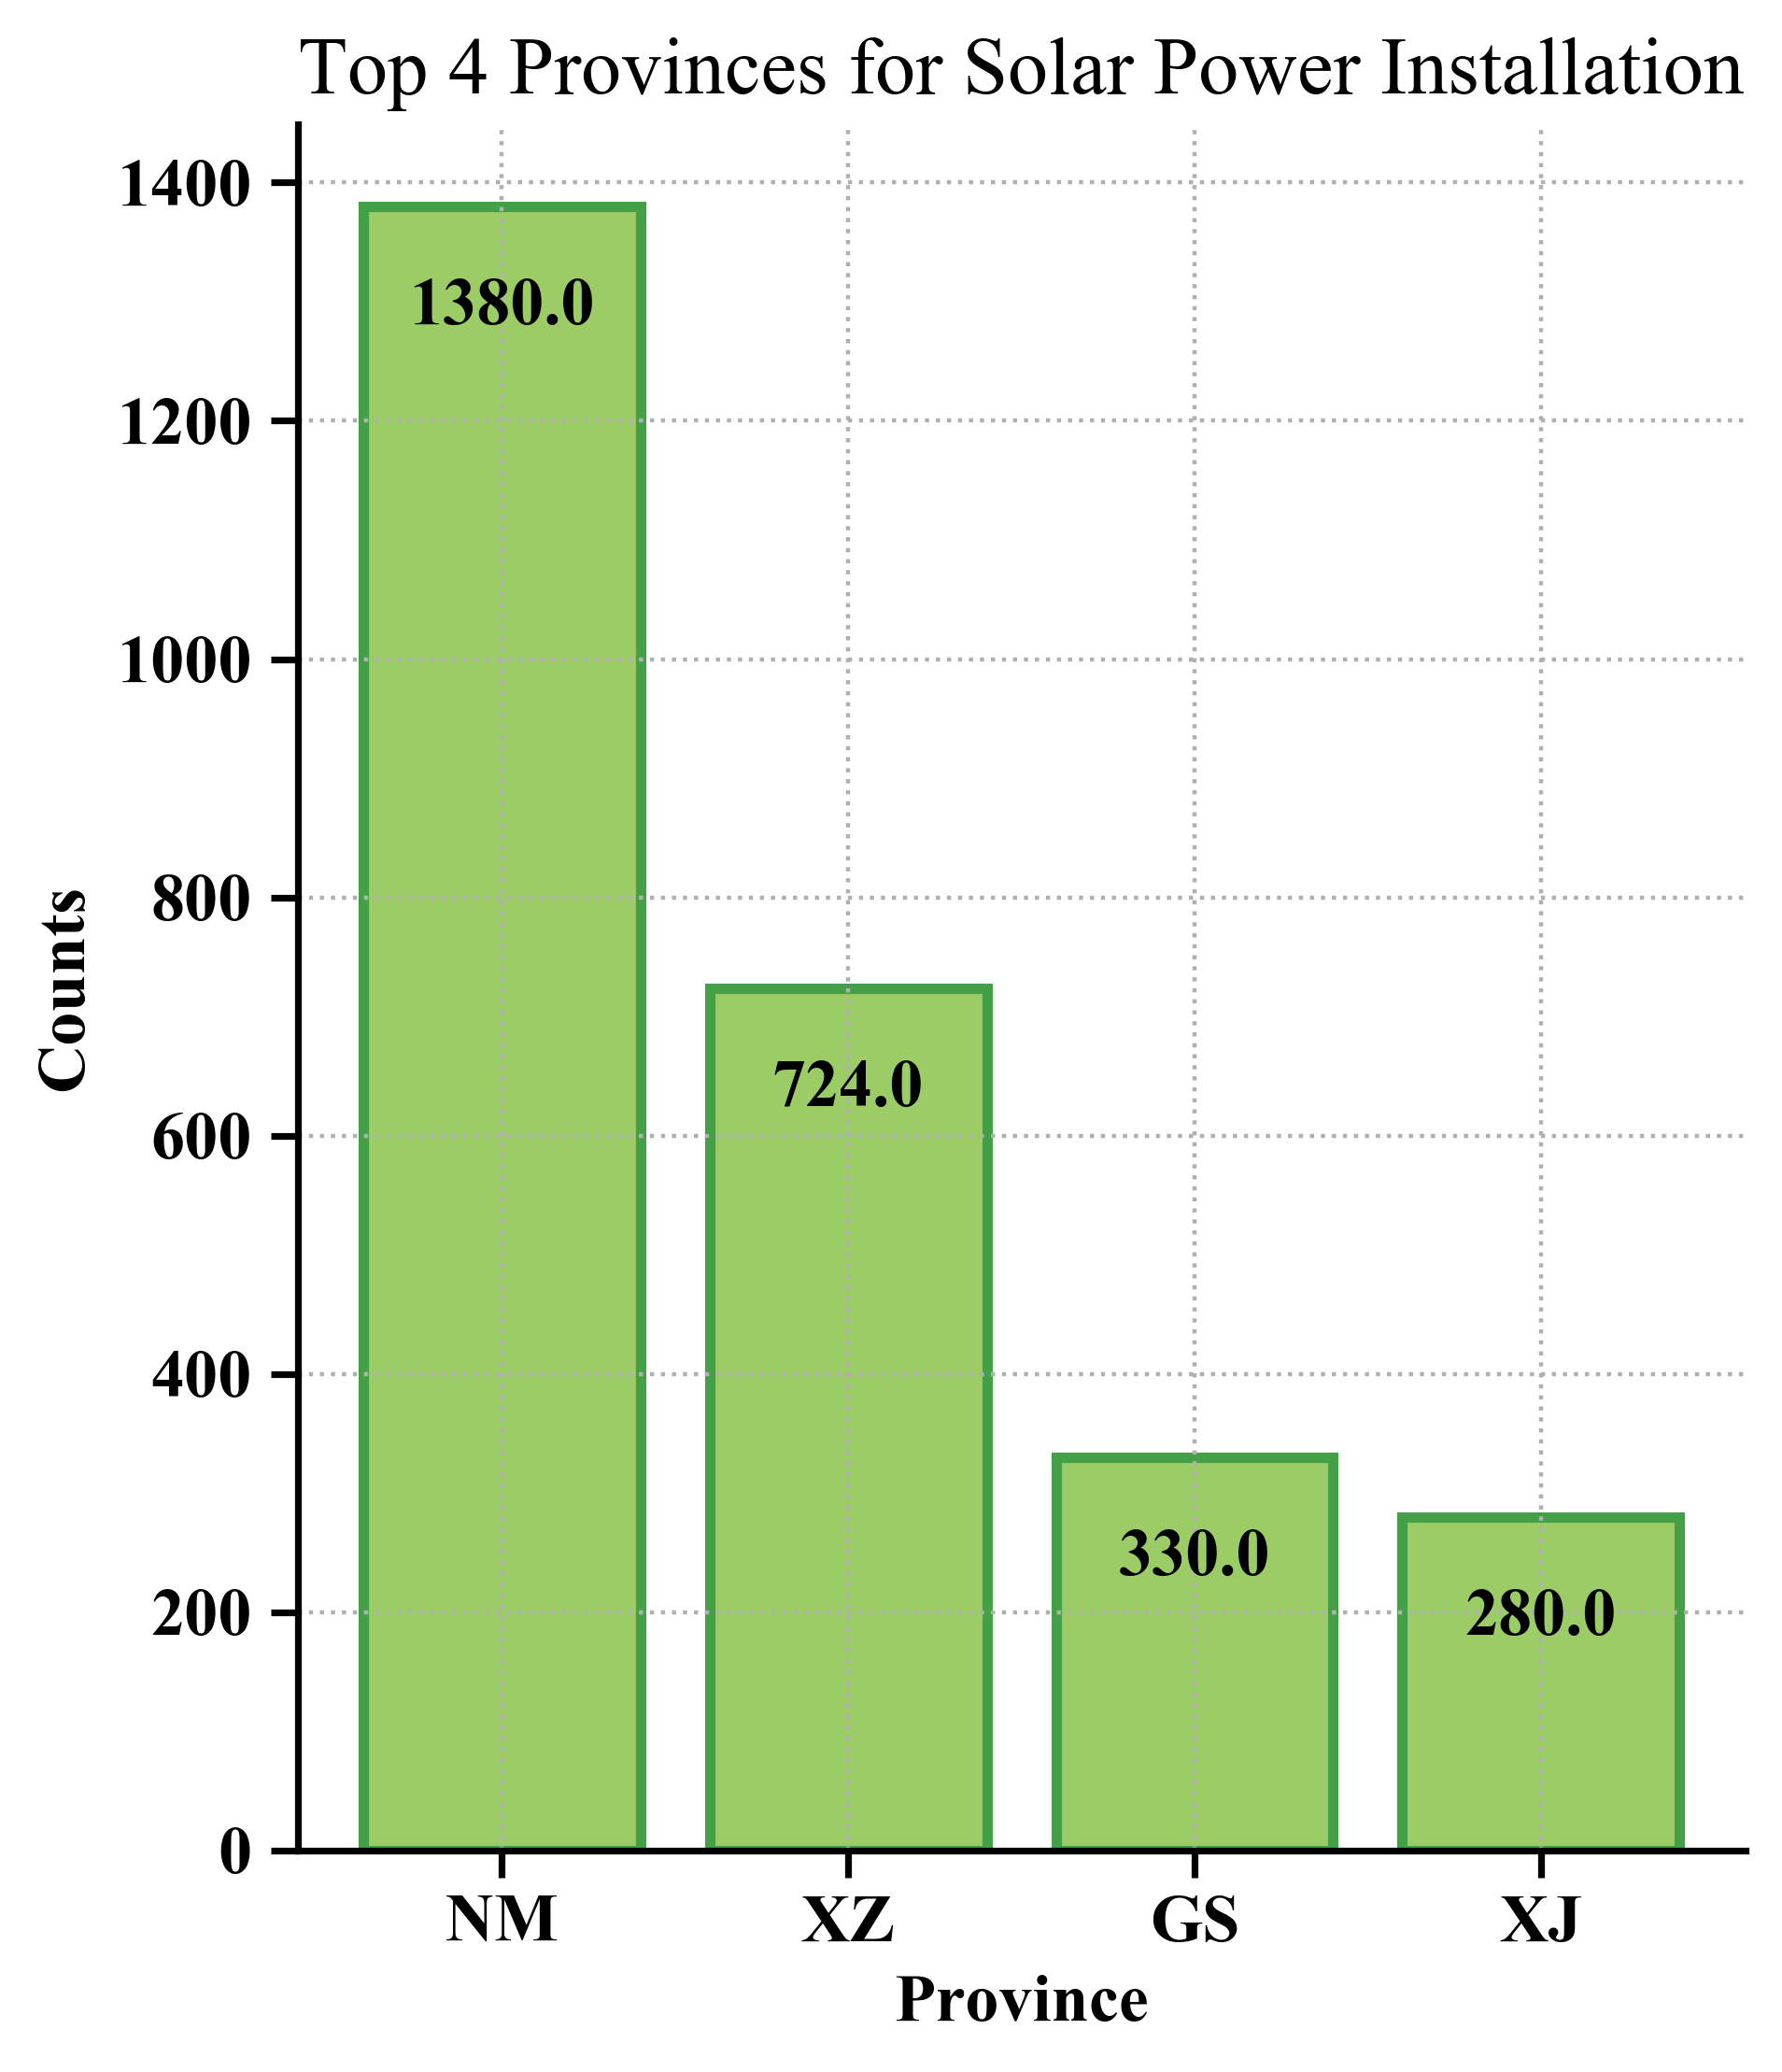

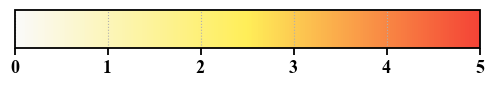

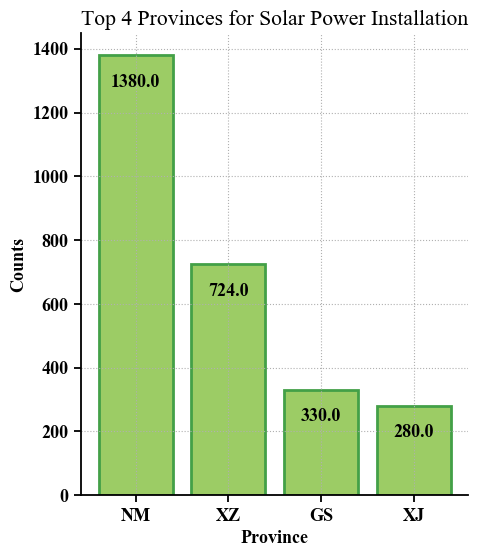

In [111]:
import folium
import geopandas as gpd
import gpxpy
import matplotlib as mpl
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# 更多API
# https://manage.thunderforest.com/dashboard
# https://cloud.maptiler.com/maps/
# https://console.tracestrack.com/explorer#
# 谷歌地图参数：lyrs(风格) = h(道路) m(标准) h(地形) s(卫星) y(卫星混合)
#             hl(语言) = zh-CN(中文) en(英文)

# 创建地图
with open('full_corners.pkl', 'rb') as f:
    full_corners = pickle.load(f)
gdf = gpd.read_file("world.zh.json")
gdf = gdf[gdf['name']=='中国']
df_full = pd.read_excel('各区块数据V4(ans).xlsx')
df_cb = pd.read_excel('各省数据.xlsx')

TileUrls = {
    "彩色地形街道": "https://tile.thunderforest.com/cycle/{z}/{x}/{y}.png?apikey=bcd7a70cf829490cbb01da32edcfa34a",
    "谷歌": "https://mt.google.com/vt/lyrs=m&x={x}&y={y}&z={z}&hl=en",
    "黑白地形国界": "https://api.maptiler.com/maps/backdrop/{z}/{x}/{y}.png?key=xS19b1djkqldyIG9Pxty",
    "黑白地形": "https://api.maptiler.com/tiles/hillshade/{z}/{x}/{y}.webp?key=xS19b1djkqldyIG9Pxty",
    "浅色街道": "http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png"
}

# 官方网站 https://python-visualization.github.io/folium/latest/user_guide.html
m = folium.Map(
    location=[36.1024,114.8947], 
    zoom_start=4,
    tiles=TileUrls["黑白地形"],
    zoom_control=False,
    attr=' ')

m.add_child(folium.LatLngPopup())
folium.GeoJson(gdf,
        style_function=lambda x: {
        'fillColor': 'black',  # 指定填充颜色
        'color': '#EC407A',
        'weight': 2,
        'fillOpacity': 0.5,
        }).add_to(m)

# 创建一个连续的颜色映射
# 先确定score的最小值和最大值，以便对score进行归一化
min_score = df_full['ans'].min()
max_score = df_full['ans'].max()

# 获取seismic颜色映射
clist=['#FAFAFA','#FFEE58','#F44336']
colormap = LinearSegmentedColormap.from_list('chaos',clist)
norm = mpl.colors.Normalize(vmin=min_score, vmax=max_score)

for index, row in df_full.iterrows():
    # 交换 (x, y) 顺序变为 (y, x) 也就是 (lat, lon)
    # 通过颜色映射获取颜色
    num = row['ans']

    # 归一化分数并获取相应颜色
    normalized_score = (num - min_score) / (max_score - min_score)

    corners = full_corners[int(row['number'])]
    corners_tran = [(corner[1], corner[0]) for corner in corners]
    if num == 0:
        weight = 0
    else:
        weight = 1
    folium.Polygon(
        locations=corners_tran,
        color=plt.cm.colors.rgb2hex(colormap(normalized_score)),
        fill=True,
        weight=weight,  # 调整边框宽度
        fill_opacity=0.65  # 调整透明度
    ).add_to(m)
    # folium.CircleMarker(location=[row['Center_Latitude'], row['Center_Longitude']], radius=1, color="#8D6E63", fill=True).add_to(m)

# 画热力图
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap),
             cax=ax, orientation='horizontal')
plt.savefig('热力图例_tmp.png',dpi=400,bbox_inches='tight', transparent=True)

# 建设风力发电机组，排名前四的省份
province_EN = {'北京市': 'BJ', '上海市': 'SH', '天津市': 'TJ', '重庆市': 'CQ', '河北省': 'HE', '山西省': 'SX', '内蒙古自治区': 'NM', '辽宁省': 'LN', '吉林省': 'JL', '黑龙江省': 'HL', '江苏省': 'JS', '浙江省': 'ZJ', '安徽省': 'AH', '福建省': 'FJ', '江西省': 'JX', '山东省': 'SD', '河南省': 'HA', '湖北省': 'HB', '湖南省': 'HN', '广东省': 'GD', '广西壮族自治区': 'GX', '海南省': 'HI', '四川省': 'SC', '贵州省': 'GZ', '云南省': 'YN', '西藏自治区': 'XZ', '陕西省': 'SN', '甘肃省': 'GS', '青海省': 'QH', '宁夏回族自治区': 'NX', '新疆维吾尔自治区': 'XJ', '台湾省': 'TW', '香港特别行政区': 'HK', '澳门特别行政区': 'MO'}
df_cb['province_EN'] = df_cb['省市区'].map(province_EN)

for index, row in df_cb.iterrows():
    df_cb.loc[index, 'counts'] = sum(df_full.loc[df_full['province'] == row['省市区'],'ans'])

# 根据 'counts' 列来排序
fig, ax = plt.subplots(figsize=(5,6))
df_cb_sorted = df_cb.sort_values(by='counts', ascending=False)
# 取出前四行
top_4 = df_cb_sorted.head(4)
# 绘制柱状图
bars = plt.bar(top_4['province_EN'], top_4['counts'],color='#9CCC65',linewidth=2,edgecolor='#43A047')
plt.xlabel('Province')
plt.ylabel('Counts')
plt.title('Top 4 Provinces for Solar Power Installation')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.08 * top_4['counts'].max(), round(yval,1), ha='center', va='bottom')
plt.savefig('装机量排名_tmp.png',dpi=400,bbox_inches='tight', transparent=True)

# 插入热力图
folium.raster_layers.ImageOverlay(
    image='热力图例_tmp.png',
    bounds=[[21.5348,76.3819], [16.3807,107.300]],      # 左上右下
).add_to(m)
# 插入条形图
folium.Marker(
    location=[27.77,118.782], 
    icon=folium.CustomIcon(
        icon_image='装机量排名_tmp.png',
        icon_size=(300, 300)
)).add_to(m)

# 
m.save('q3热力图_5.html')
m